This notebook was used to produce Figure 7 and the animated cell-cycles videos of
>Anton Osokin, Anatole Chessel, Rafael E. Carazo Salas, Federico Vaggi<br>
GANs for Biological Image Synthesis<br>
In ICCV, 2017

In [1]:
import sys
import math
import numpy as np
from PIL import Image
import pylab as plt
from scipy.misc import imresize
from moviepy.editor import VideoClip

import torch
from torch.autograd import Variable
import torchvision.utils as vutils

sys.path.insert(0, '../../code')
import dcgan_starshaped
from utils import pad_channels

torch.manual_seed(42)

%matplotlib inline

In [2]:
# setup the network
network_path = '../../models/size-48-80_6class_wgangp-star-shaped-adam/netG_iter_50000.pth'
image_height = 48
image_width = 80
nz = 100
nc = 2
ngf = 64
n_classes= 6
red_portion = 0.5
    
netG = dcgan_starshaped.DCGAN_G_starShaped((image_height, image_width), nz, nc, ngf,
                                           n_classes, red_portion=red_portion)
netG.load_state_dict(torch.load(network_path))
print(netG)
netG.eval()

DCGAN_G_starShaped (
  (main): ModuleList (
    (0): CnvTranspose2d_starShape (
      (convt_red): ConvTranspose2d(50, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
      (batchnorm_red): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (convt_green): ModuleList (
        (0): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (1): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (2): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (3): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (4): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (5): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
      )
      (batchnorm_green): ModuleList (
        (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (2): BatchN

DCGAN_G_starShaped (
  (main): ModuleList (
    (0): CnvTranspose2d_starShape (
      (convt_red): ConvTranspose2d(50, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
      (batchnorm_red): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (convt_green): ModuleList (
        (0): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (1): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (2): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (3): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (4): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (5): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
      )
      (batchnorm_green): ModuleList (
        (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (2): BatchN

In [3]:
def generate_images(noise):
    images = netG(Variable(noise)).data.cpu()
    images_01 = images * 0.5 + 0.5
    return images_01

batch_size = 64
noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)

images_01 = generate_images(noise)

In [4]:
def tensor_to_np(im):
    im = im.mul(255).clamp(0, 255).byte()
    if im.dim() == 3:
        im = im.permute(1, 2, 0)
    elif im.dim() == 4:
        im = im.permute(0, 2, 3, 1)
    return im.numpy()
    
def grid_to_image(grid):
    ndarr = tensor_to_np(grid)
    im = Image.fromarray(ndarr)
    return im

def show_images(im):
    fig, axes = plt.subplots(figsize=(18, 80))
    axes.imshow(im, interpolation='nearest')
    axes.set_axis_off()
    fig.show()

def collate_images(images_01, separate_greens=False):
    red_only = images_01[0].clone().unsqueeze(0)
    red_only[:,:,1,:,:].fill_(0)
    if separate_greens:
        images_01[:,:,0,:,:].fill_(0)
    images_01 = torch.cat([red_only, images_01], 0)

    n_cols = images_01.size(0)
    ims = images_01.transpose(0, 1).contiguous().view(-1, images_01.size(2), images_01.size(3), images_01.size(4))
    ims = pad_channels(ims, 3, value=0)
    grid = vutils.make_grid(ims, nrow=n_cols, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
    return grid    

def show_images_with_red(images_01, separate_greens=False):
    grid = collate_images(images_01, separate_greens=separate_greens)
    im = grid_to_image(grid)
    show_images(im)
    
def make_gif(images, fname, scale=2.0, duration=5):
    print(' Making video from', len(images), 'images')
    
    def make_frame(t):
        try:
            x = images[int(len(images)/duration*t)]
        except:
            x = images[-1]
            
        #x = imresize((x+1)/2, 3.0, interp='bicubic')
        x = imresize(x, scale, interp='bicubic')
        return x
    
    clip = VideoClip(make_frame, duration=duration)
    clip.write_gif(fname, fps = len(images) / duration)
    
def slerp_step(val, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    if val <= 0:
        return low
    elif val >= 1:
        return high
    high_, low_ = high.view(-1), low.view(-1)
    omega = math.acos(torch.dot(low_/torch.norm(low_), high_/torch.norm(high_)))
    so = math.sin(omega)
    return math.sin((1.0-val)*omega) / so * low + math.sin(val*omega) /so * high
# mono_to_bipolar = np.array([slerp(i, monopolar_cell, bipolar_cell) for i in interval])

def slerp(low, high, n_steps=64):
    return torch.stack([slerp_step(float(i), low, high)
                        for i in np.linspace(0, 1, n_steps)], 0)

def interpolate_images(noise, frame_start, frame_middle, frame_end):
    noise_interp_t_1 = slerp(noise[frame_start], noise[frame_middle])
    noise_interp_t_2 = slerp(noise[frame_middle], noise[frame_end])
    noise_interp_t = torch.cat([noise_interp_t_1, noise_interp_t_2[1:]], 0)
    return generate_images(noise_interp_t)

def make_movie(movie_name, noise, frame_start, frame_middle, frame_end, scale=2.0, duration=5):
    images_inter_01 = interpolate_images(noise, frame_start, frame_middle, frame_end)
    
    image_movie = images_inter_01[0].clone()
    image_movie[:,1,:,:].fill_(-1)  # remove the green channel
    
    for i_class in range(n_classes):
        image_movie = torch.cat([image_movie, images_inter_01[i_class]], 3)
    image_movie = pad_channels(image_movie, 3, value=0.0)    
    image_movie = tensor_to_np(image_movie)

    make_gif(image_movie, movie_name, scale=scale, duration=duration)


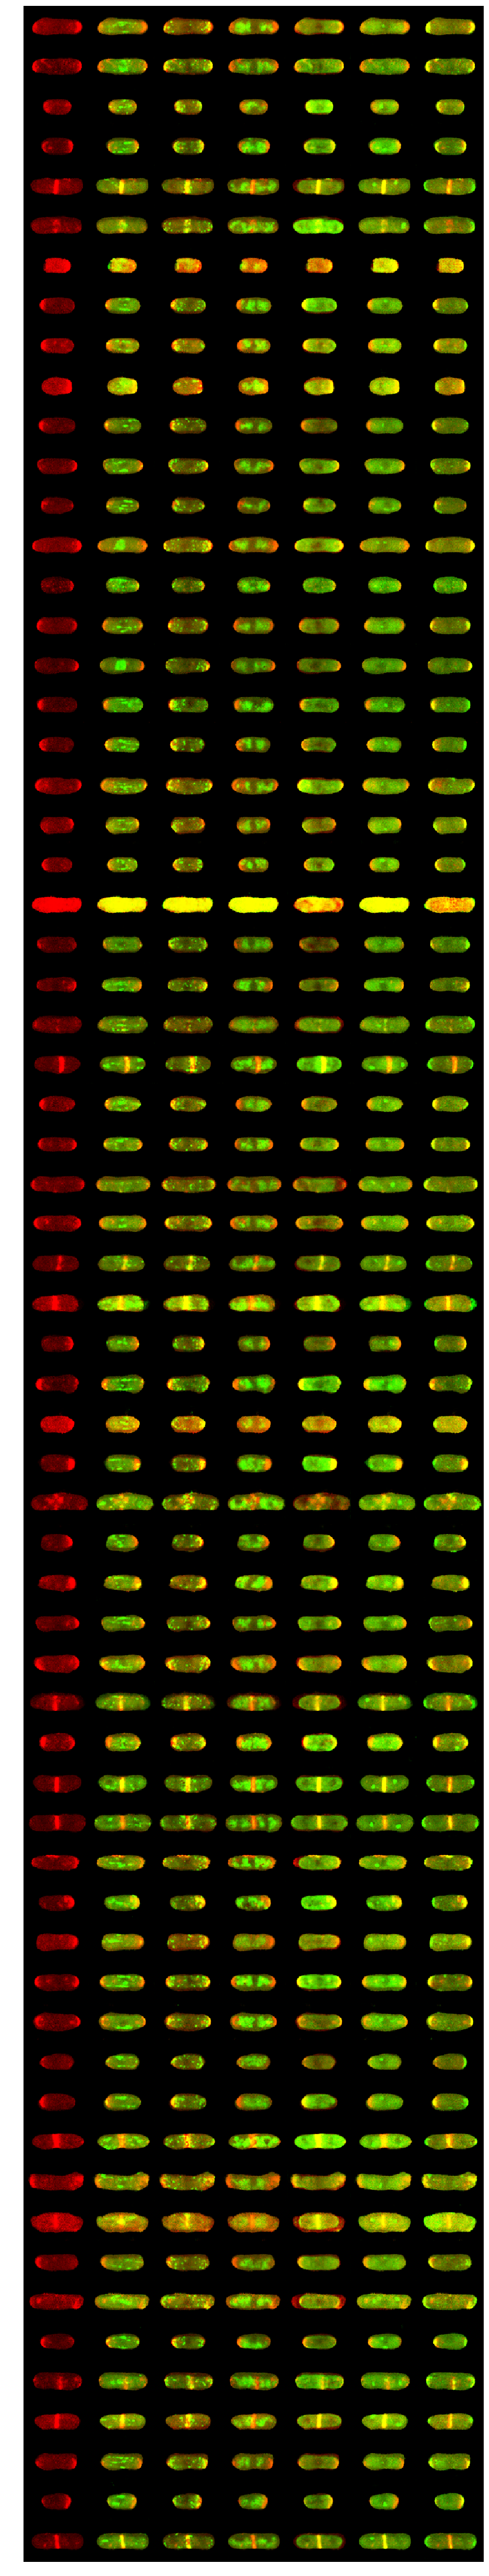

In [5]:
show_images_with_red(images_01)

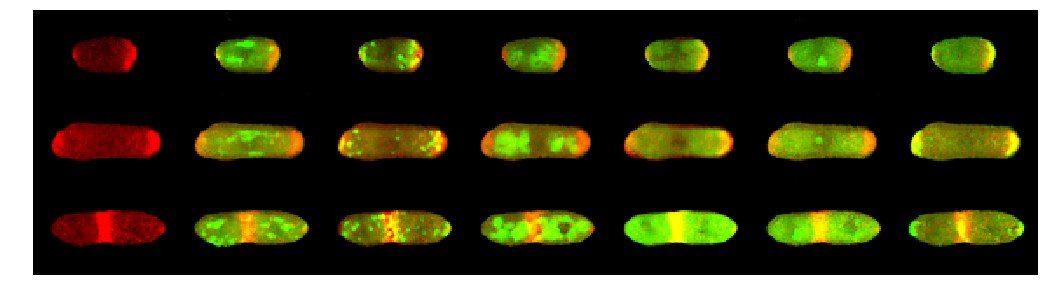

In [6]:
frame_start = 62
frame_middle = 0
frame_end = 53

show_images_with_red(images_01[:, torch.LongTensor([frame_start, frame_middle, frame_end]), :, :])

In [7]:
images_interpolated = interpolate_images(noise, frame_start, frame_middle, frame_end)

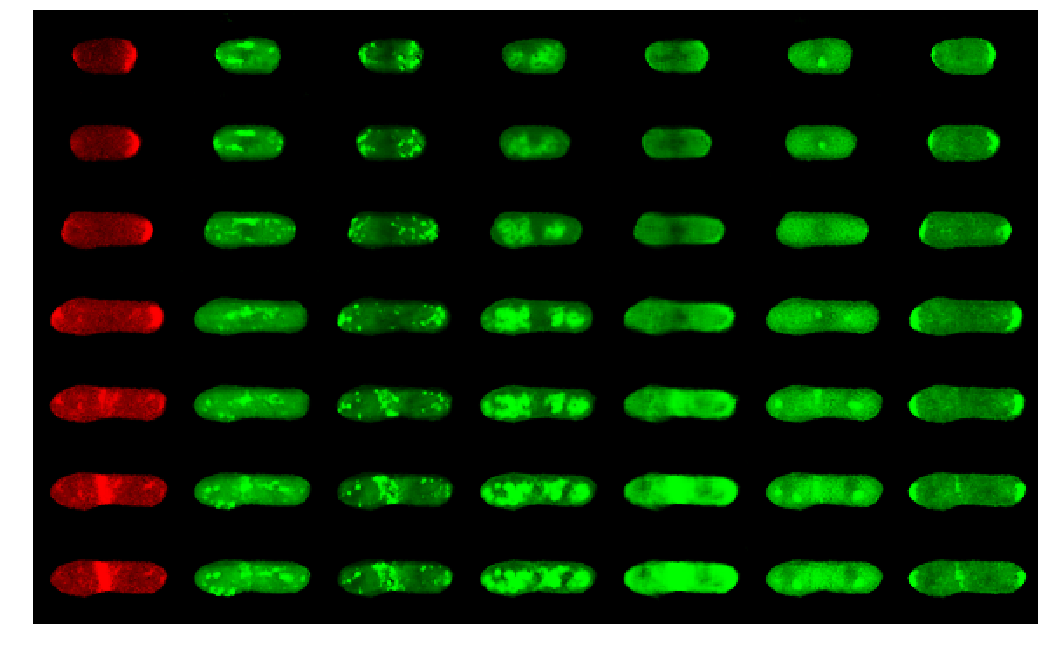

In [8]:
ids = torch.LongTensor([0, 30, 50, 70, 78, 90, 100])
show_images_with_red(images_interpolated[:,ids,:,:,:], separate_greens=True)

In [9]:
make_movie('lin_movie1.gif', noise, frame_start, frame_middle, frame_end)

 Making video from 127 images

[MoviePy] Building file lin_movie1.gif with imageio


 99%|█████████▉| 127/128 [00:07<00:00, 14.68it/s]


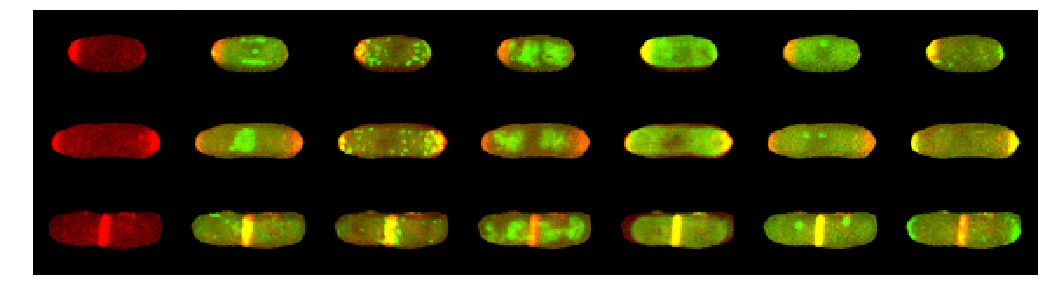

In [10]:
frame_start = 7
frame_middle = 13
frame_end = 4

show_images_with_red(images_01[:, torch.LongTensor([frame_start, frame_middle, frame_end]), :, :])

In [11]:
make_movie('lin_movie2.gif', noise, frame_start, frame_middle, frame_end)

 Making video from 127 images

[MoviePy] Building file lin_movie2.gif with imageio


 99%|█████████▉| 127/128 [00:07<00:00, 16.47it/s]


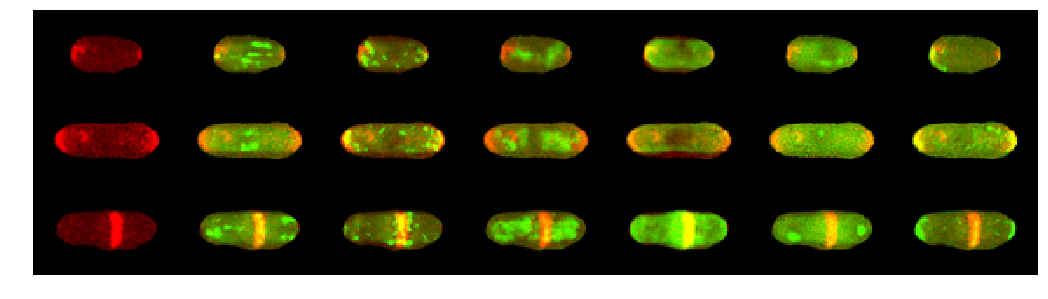

In [12]:
frame_start = 12
frame_middle = 30
frame_end = 26

show_images_with_red(images_01[:, torch.LongTensor([frame_start, frame_middle, frame_end]), :, :])

In [13]:
make_movie('lin_movie3.gif', noise, frame_start, frame_middle, frame_end)

 Making video from 127 images

[MoviePy] Building file lin_movie3.gif with imageio


 99%|█████████▉| 127/128 [00:07<00:00, 16.47it/s]


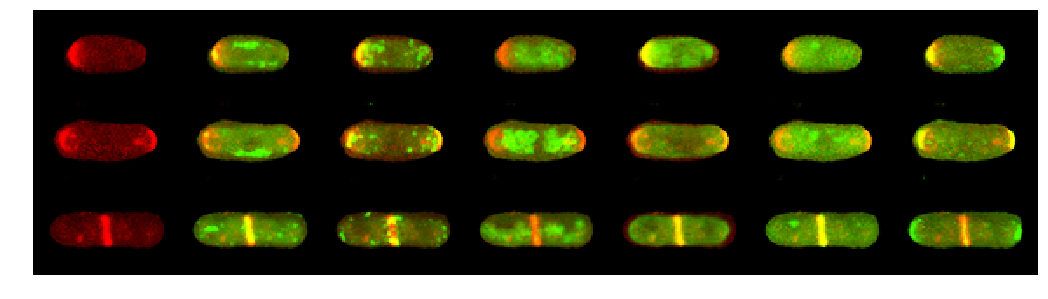

In [14]:
frame_start = 52
frame_middle = 50
frame_end = 63

show_images_with_red(images_01[:, torch.LongTensor([frame_start, frame_middle, frame_end]), :, :])

In [15]:
make_movie('lin_movie4.gif', noise, frame_start, frame_middle, frame_end)

 Making video from 127 images

[MoviePy] Building file lin_movie4.gif with imageio


 99%|█████████▉| 127/128 [00:07<00:00, 16.11it/s]
